In [5]:
!pip install pyTsetlinMachine

In [6]:
import pandas as pd

df = pd.read_csv("FlowStatsfile.csv")
df = df.dropna()
print(df.head())
print(df.shape)


      timestamp  datapath_id                     flow_id    ip_src  tp_src  \
0  1.589933e+09            1  10.0.0.1505010.0.0.3542466  10.0.0.1    5050   
1  1.589933e+09            1  10.0.0.35424610.0.0.150506  10.0.0.3   54246   
2  1.589933e+09            1  10.0.0.35424610.0.0.550501  10.0.0.3   54246   
3  1.589933e+09            1  10.0.0.55424610.0.0.350501  10.0.0.5   54246   
4  1.589933e+09            2         10.0.0.3010.0.0.501  10.0.0.3       0   

     ip_dst  tp_dst  ip_proto  icmp_code  icmp_type  ...  idle_timeout  \
0  10.0.0.3   54246         6         -1         -1  ...            20   
1  10.0.0.1    5050         6         -1         -1  ...            20   
2  10.0.0.5    5050         1          0          8  ...            20   
3  10.0.0.3    5050         1          0          0  ...            20   
4  10.0.0.5       0         1          0          8  ...            20   

   hard_timeout  flags  packet_count   byte_count  packet_count_per_second  \
0       

In [7]:
import re

def clean_merged_row(value):
    value = str(value)

    ips = re.findall(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', value)

    nums = re.findall(r'\b\d+\b', value)

    for ip in ips:
        for part in ip.split('.'):
            if part in nums:
                nums.remove(part)


    if len(ips) == 0:
        ips = [None, None]
    elif len(ips) == 1:
        ips.append(None)

    tp_src = int(nums[0]) if len(nums) > 0 else 0
    tp_dst = int(nums[1]) if len(nums) > 1 else 0
    flow_id = int(nums[2]) if len(nums) > 2 else 0

    return {
        "ip_src": ips[0],
        "ip_dst": ips[1],
        "tp_src": tp_src,
        "tp_dst": tp_dst,
        "flow_id": flow_id
    }


In [8]:
cleaned = df['flow_id'].apply(clean_merged_row)
cleaned_df = pd.DataFrame(cleaned.tolist())


In [9]:
df[['ip_src', 'ip_dst', 'tp_src', 'tp_dst', 'flow_id']] = cleaned_df


In [10]:
import ipaddress

def ip_to_int(ip):
    if ip is None or ip == "":
        return 0
    return int(ipaddress.IPv4Address(ip))

df['ip_src'] = df['ip_src'].apply(ip_to_int)
df['ip_dst'] = df['ip_dst'].apply(ip_to_int)


In [11]:
X = df.drop('label', axis=1)
y = df['label']

In [12]:
import numpy as np

def binarize_features_fixed(X, n_bins=10):
    X_bin = []

    for col in X.columns:
        values = X[col].astype(float).values  # ensured numeric

        # handle constant column
        if values.min() == values.max():
            bin_cols = np.zeros((len(values), 1), dtype=int)
            X_bin.append(bin_cols)
            continue

        # threshold bins
        thresholds = np.linspace(values.min(), values.max(), n_bins)

        # >= threshold gives binary features
        bin_cols = [(values >= t).astype(int) for t in thresholds]
        X_bin.append(np.array(bin_cols).T)

    return np.concatenate(X_bin, axis=1)

X_bin = binarize_features_fixed(X, n_bins=10)
print("Binary shape:", X_bin.shape)


Binary shape: (2667523, 165)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y, test_size=0.2, random_state=42
)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [14]:
from pyTsetlinMachine.tm import MultiClassConvolutionalTsetlinMachine2D

tm = MultiClassConvolutionalTsetlinMachine2D(
    number_of_clauses=2000,
    T=8000,
    s=10.0,
    patch_dim=(1, X_bin.shape[1])  # 1D patch covering all features
)


In [ ]:
epochs = 50

for epoch in range(epochs):
    tm.fit(X_train, y_train, epochs=1)
    acc = 100 * (tm.predict(X_test) == y_test).mean()
    print(f"Epoch {epoch+1}/{epochs} - Test Accuracy: {acc:.2f}%")


In [25]:
epochs = 50

for epoch in range(epochs):
    tm.fit(X_train, y_train, epochs=1)
    acc = 100 * (tm.predict(X_test) == y_test).mean()
    print(f"Epoch {epoch+1}/{epochs} - Test Accuracy: {acc:.2f}%")


Epoch 1/50 - Test Accuracy: 97.12%
Epoch 2/50 - Test Accuracy: 97.46%
Epoch 3/50 - Test Accuracy: 97.83%
Epoch 4/50 - Test Accuracy: 98.05%
Epoch 5/50 - Test Accuracy: 98.27%
Epoch 6/50 - Test Accuracy: 98.54%
Epoch 7/50 - Test Accuracy: 98.71%
Epoch 8/50 - Test Accuracy: 98.93%
Epoch 9/50 - Test Accuracy: 99.08%
Epoch 10/50 - Test Accuracy: 99.20%
Epoch 11/50 - Test Accuracy: 99.26%
Epoch 12/50 - Test Accuracy: 99.31%
Epoch 13/50 - Test Accuracy: 99.34%
Epoch 14/50 - Test Accuracy: 99.38%
Epoch 15/50 - Test Accuracy: 99.41%
Epoch 16/50 - Test Accuracy: 99.43%
Epoch 17/50 - Test Accuracy: 99.45%
Epoch 18/50 - Test Accuracy: 99.49%
Epoch 19/50 - Test Accuracy: 99.52%
Epoch 20/50 - Test Accuracy: 99.55%
Epoch 21/50 - Test Accuracy: 99.58%
Epoch 22/50 - Test Accuracy: 99.61%
Epoch 23/50 - Test Accuracy: 99.63%
Epoch 24/50 - Test Accuracy: 99.65%
Epoch 25/50 - Test Accuracy: 99.66%
Epoch 26/50 - Test Accuracy: 99.67%
Epoch 27/50 - Test Accuracy: 99.68%
Epoch 28/50 - Test Accuracy: 99.69%
E

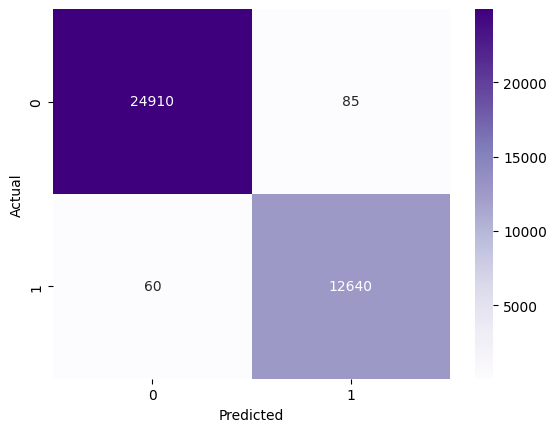

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = tm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
